In [1]:
# modified from https://www.kaggle.com/code/baekseungyun/gpt-2-with-huggingface-pytorch

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/ECE1786_dataset/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ECE1786_dataset


In [3]:
!pip install transformers
!pip install accelerate
!pip install huggingface_hub

     |████████████████████████████████| 5.8 MB 5.9 MB/s eta 0:00:01
  Using cached tokenizers-0.13.2-cp38-cp38-macosx_10_11_x86_64.whl (3.8 MB)
  Using cached accelerate-0.15.0-py3-none-any.whl (191 kB)


In [4]:
import torch
import matplotlib.pyplot as plt
from transformers import set_seed, GPT2Config, GPT2Tokenizer, GPT2ForSequenceClassification, AdamW, get_cosine_schedule_with_warmup
from accelerate import Accelerator
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, accuracy_score
import gc
import os
from huggingface_hub import notebook_login
import json

In [2]:
notebook_login()
# huggingface-cli login

In [2]:
set_seed(114514)
accelerator = Accelerator()

model_config = GPT2Config.from_pretrained('gpt2', num_labels=2) # Binary Classification
model = GPT2ForSequenceClassification.from_pretrained('gpt2', config=model_config)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left" # Very Important
tokenizer.pad_token = tokenizer.eos_token

model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
import os
import pandas as pd
from torch.utils.data import Dataset

class ChatDataset(Dataset):
    def __init__(self, train=True):
        super().__init__()
        self.train = train
        if train:
            self.data = pd.read_csv('final_dataset_suicide_train_huggingface.csv')
        else:
            self.data = pd.read_csv('final_dataset_suicide_test_huggingface.csv')
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        record = self.data.iloc[index]
        text = record['prompt']
        # if self.train:
        #     return {'prompt': text, 'completion': record['completion']}
        # else:
        # return {'prompt': text, 'completion': '0'}
        return {'prompt': text, 'completion': record['completion']}

train_dataset = ChatDataset(train=True)
test_dataset = ChatDataset(train=False)

In [4]:
class Gpt2ClassificationCollator(object):
    def __init__(self, tokenizer, max_seq_len=None):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        
        return
    
    def __call__(self, sequences):
        texts = [sequence['prompt'] for sequence in sequences]
        labels = [(sequence['completion']) for sequence in sequences]
        inputs = self.tokenizer(text=texts,
                                return_tensors='pt',
                                padding=True,
                                truncation=True,
                                max_length=self.max_seq_len)
        numeric_labels = []
        for label in labels:
            if label == 'suicide':
                numeric_labels.append(1)
            else:
                numeric_labels.append(0)
        inputs.update({'labels': torch.tensor(numeric_labels)})
        
        return inputs

gpt2classificationcollator = Gpt2ClassificationCollator(tokenizer=tokenizer, max_seq_len=64)

In [5]:
train_size = int(len(train_dataset))
val_size = int(len(test_dataset))
batch_size = 32
train_dataset, val_dataset = random_split(train_dataset, [train_size, len(train_dataset) - train_size])
test_dataset, _ = random_split(test_dataset, [val_size, len(test_dataset) - val_size])

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              collate_fn=gpt2classificationcollator)
val_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            collate_fn=gpt2classificationcollator)

In [6]:
total_epochs = 5

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters,
                  lr=1e-5,
                  eps=1e-8)

num_train_steps = len(train_dataloader) * total_epochs
num_warmup_steps = int(num_train_steps * 0.1) 

lr_scheduler = get_cosine_schedule_with_warmup(optimizer,
                                               num_warmup_steps=num_warmup_steps,
                                               num_training_steps = num_train_steps)
# Register the LR scheduler
accelerator.register_for_checkpointing(optimizer)
accelerator.register_for_checkpointing(lr_scheduler)
accelerator.register_for_checkpointing(model)

/home/shijiaka/miniconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [7]:
def train(dataloader, optimizer, scheduler, device_):
    i = 0
    global model
    model.train()
    
    prediction_labels = []
    true_labels = []
    
    total_loss = []
    
    for batch in dataloader:
        torch.cuda.empty_cache()
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device_) for k, v in batch.items()}
        
        
        outputs = model(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach().cpu().numpy()
        total_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # prevent exploding gradient

        optimizer.step()
        scheduler.step()
        
        prediction_labels += logits.argmax(axis=-1).flatten().tolist()
        del batch
        gc.collect()

        # model.push_to_hub("safechat-gpt2")
        # tokenizer.push_to_hub("safechat-gpt2")
        # model_config.push_to_hub("safechat-gpt2")
    
        print("=== batch {} ===".format(i))
        i += 1
    return true_labels, prediction_labels, total_loss

def validation(dataloader, device_):
    i = 0
    global model
    model.eval()
    
    prediction_labels = []
    true_labels = []
    
    total_loss = []
    
    for batch in dataloader:
        torch.cuda.empty_cache()
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device_) for k, v in batch.items()}
        
        with torch.no_grad():
            outputs = model(**batch)
            loss, logits = outputs[:2]
            logits = logits.detach().cpu().numpy()
            total_loss.append(loss.item())

            prediction_labels += logits.argmax(axis=-1).flatten().tolist()
        del batch
        gc.collect()
        print("=== batch {} ===".format(i))
        i += 1
        
    return true_labels, prediction_labels, total_loss

In [8]:
accelerator.save_state("./my_gpt2")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

all_loss = {'train_loss': [], 'val_loss': []}
all_acc = {'train_acc': [], 'val_acc': []}

for epoch in range(total_epochs):
    y, y_pred, train_loss = train(train_dataloader, optimizer, lr_scheduler, device)
    train_acc = accuracy_score(y, y_pred)
    
    y, y_pred, val_loss = validation(val_dataloader, device)
    val_acc = accuracy_score(y, y_pred)
    
    all_loss['train_loss'] += train_loss
    all_loss['val_loss'] += val_loss
    
    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)

    if not os.path.exists("checkpoints"):
        os.makedirs("checkpoints")
    model.save_pretrained("checkpoints/safechat-gpt2-cp{}".format(epoch))
    with open("checkpoints/safechat-loss-cp{}".format(epoch), "w") as outfile1:
        json.dump(all_loss, outfile1)
    with open("checkpoints/safechat-acc-cp{}".format(epoch), "w") as outfile2:
        json.dump(all_acc, outfile2)
    
    print(f'Epoch: {epoch}, train_loss: {torch.tensor(train_loss).mean():.3f}, train_acc: {train_acc:.3f}, val_loss: {torch.tensor(val_loss).mean():.3f}, val_acc: {val_acc:.3f}') 

=== batch 0 ===
=== batch 1 ===
=== batch 2 ===
=== batch 3 ===
=== batch 4 ===
=== batch 5 ===
=== batch 6 ===
=== batch 7 ===
=== batch 8 ===
=== batch 9 ===
=== batch 10 ===
=== batch 11 ===
=== batch 12 ===
=== batch 13 ===
=== batch 14 ===
=== batch 15 ===
=== batch 16 ===
=== batch 17 ===
=== batch 18 ===
=== batch 19 ===
=== batch 20 ===
=== batch 21 ===
=== batch 22 ===
=== batch 23 ===
=== batch 24 ===
=== batch 25 ===
=== batch 26 ===
=== batch 27 ===
=== batch 28 ===
=== batch 29 ===
=== batch 30 ===
=== batch 31 ===
=== batch 32 ===
=== batch 33 ===
=== batch 34 ===
=== batch 35 ===
=== batch 36 ===
=== batch 37 ===
=== batch 38 ===
=== batch 39 ===
=== batch 40 ===
=== batch 41 ===
=== batch 42 ===
=== batch 43 ===
=== batch 44 ===
=== batch 45 ===
=== batch 46 ===
=== batch 47 ===
=== batch 48 ===
=== batch 49 ===
=== batch 50 ===
=== batch 51 ===
=== batch 52 ===
=== batch 53 ===
=== batch 54 ===
=== batch 55 ===
=== batch 56 ===
=== batch 57 ===
=== batch 58 ===
=== bat

In [9]:
with open("checkpoints/safechat-acc-cp{}".format(total_epochs - 1), "r") as f:
        all_acc = json.load(f)
with open("checkpoints/safechat-loss-cp{}".format(total_epochs - 1), "r") as f:
        all_loss = json.load(f)

In [10]:
print(len(all_loss['train_loss']))
print(len(all_loss['val_loss']))
print(len(all_acc['train_acc']))
print(len(all_acc['val_acc']))

27460
6865
5
5


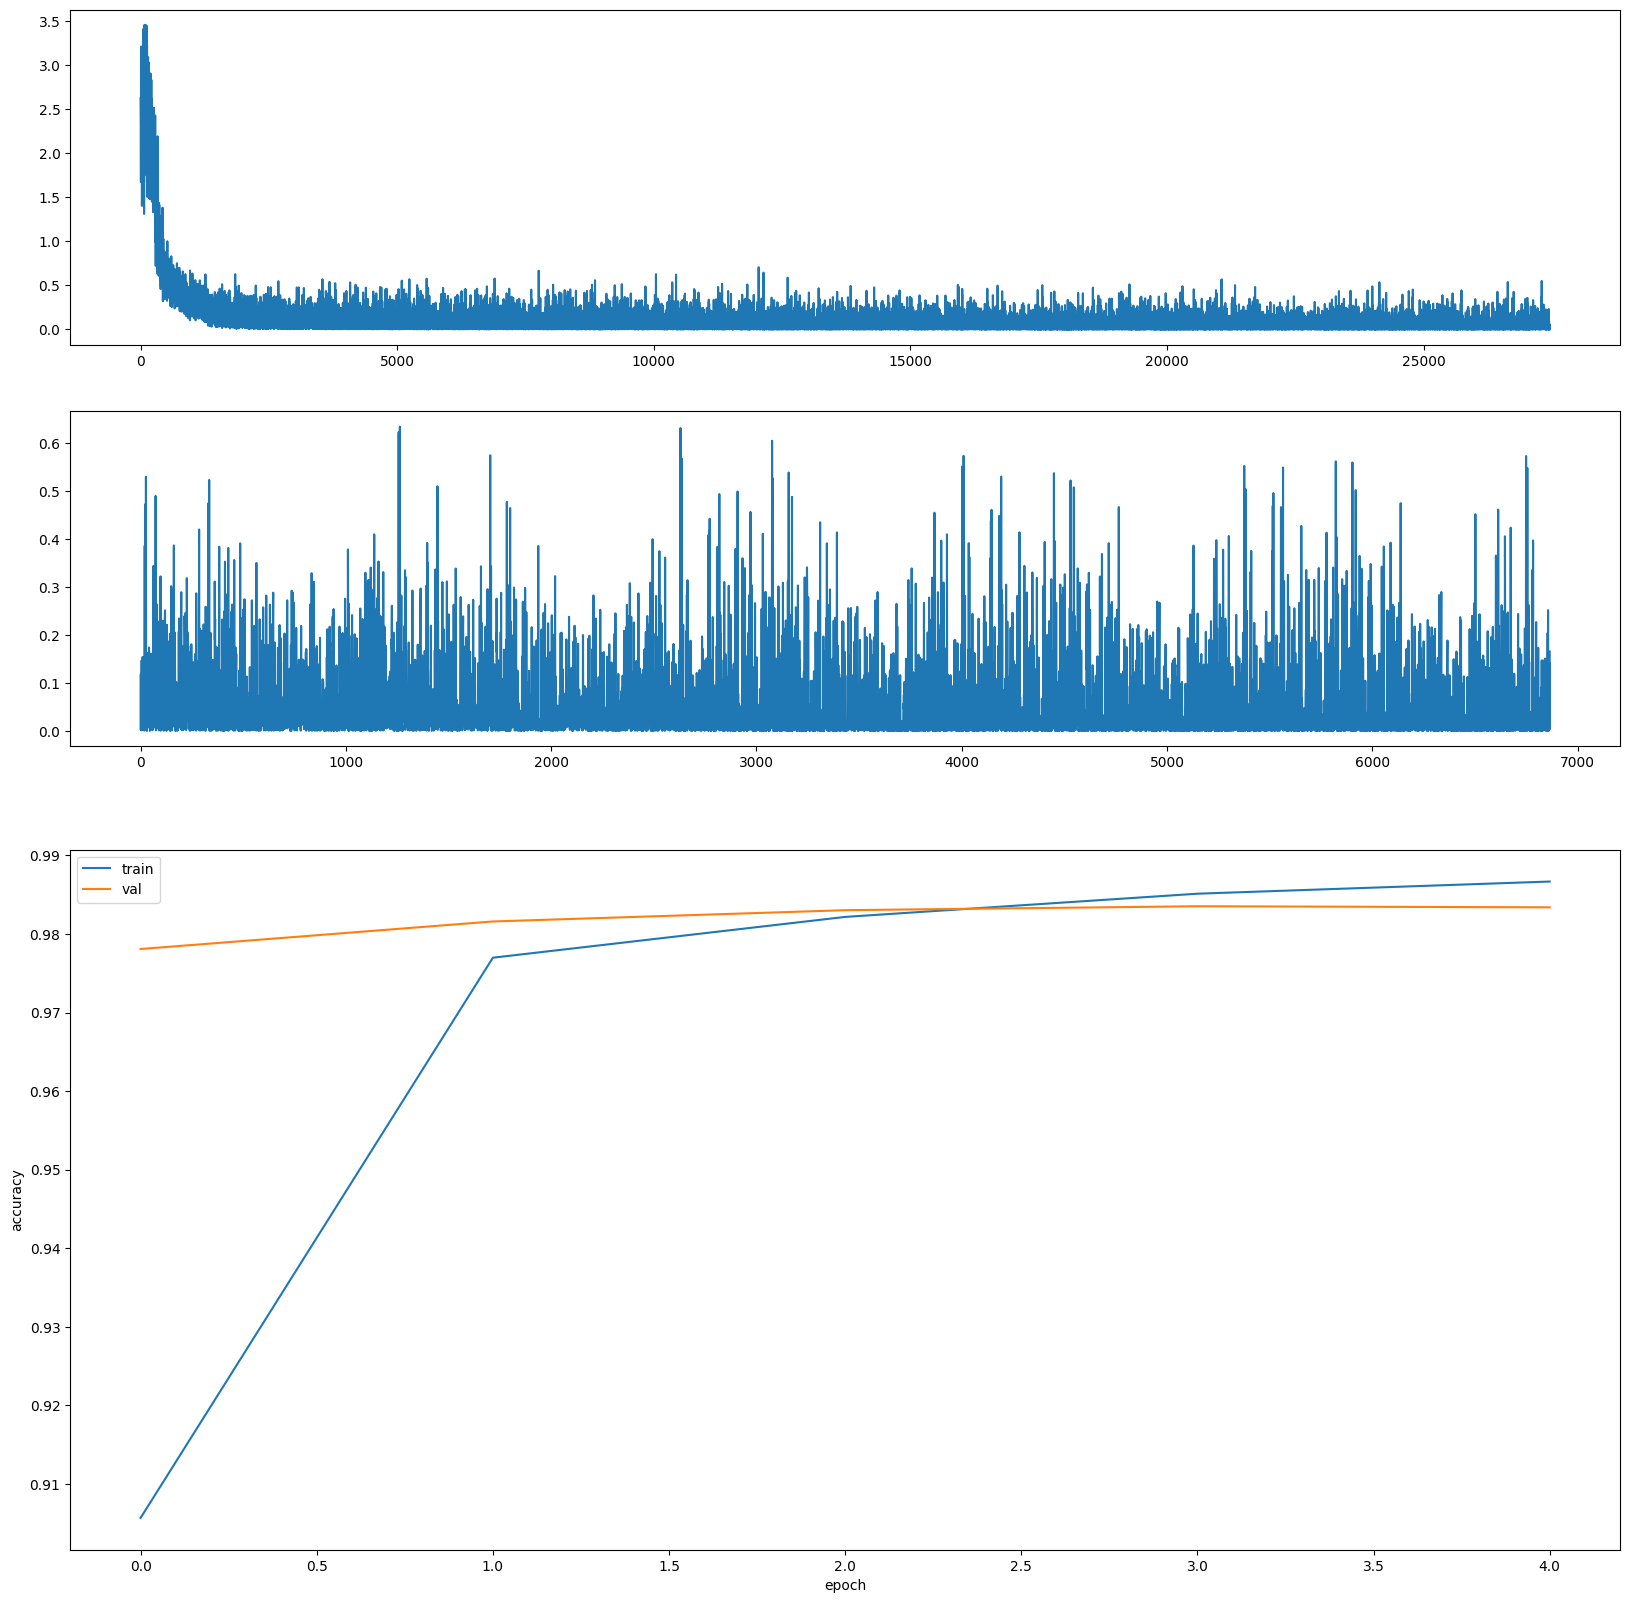

In [11]:
fig = plt.figure(figsize=(20,20))
a = fig.add_subplot(4, 1, 1)
b = fig.add_subplot(4, 1, 2)
c = fig.add_subplot(2, 1, 2)
a.plot(all_loss['train_loss'])
b.plot(all_loss['val_loss'])
c.plot(all_acc['train_acc'])
c.plot(all_acc['val_acc'])
c.set(xlabel='epoch', ylabel='accuracy')
c.legend(['train', 'val'])

In [ ]:
# Restore previous state
accelerator.load_state("./my_gpt2")

In [ ]:
model.push_to_hub("safechat-gpt2")
tokenizer.push_to_hub("safechat-gpt2")
model_config.push_to_hub("safechat-gpt2")
model.save_pretrained("safechat-gpt2")

## Qualitative test

In [5]:
def get_result(output):
    if output == 0:
        return 'non-suicide'
    return 'suicide'

In [ ]:
notebook_login()

In [6]:
model_config = GPT2Config.from_pretrained('NoNameForMe/safechat-gpt2', num_labels=2) # Binary Classification
model = GPT2ForSequenceClassification.from_pretrained('NoNameForMe/safechat-gpt2', config=model_config)

tokenizer = GPT2Tokenizer.from_pretrained('NoNameForMe/safechat-gpt2')
tokenizer.padding_side = "left" # Very Important
tokenizer.pad_token = tokenizer.eos_token

model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id

In [10]:
inputs = tokenizer("I want to suicide.", return_tensors='pt', padding=True, truncation=True, max_length=None)
get_result(model(**inputs)["logits"].argmax(axis=-1).item())

'suicide'

In [11]:
inputs = tokenizer("I am happy.", return_tensors='pt', padding=True, truncation=True, max_length=None)
get_result(model(**inputs)["logits"].argmax(axis=-1).item())

'non-suicide'

In [7]:
inputs = tokenizer("He wants to suicide.", return_tensors='pt', padding=True, truncation=True, max_length=None)
get_result(model(**inputs)["logits"].argmax(axis=-1).item())

'suicide'